# <center> HydroCrisis - Forecasting Droughts through Weather and Soil Data Using Time Series Models </center>

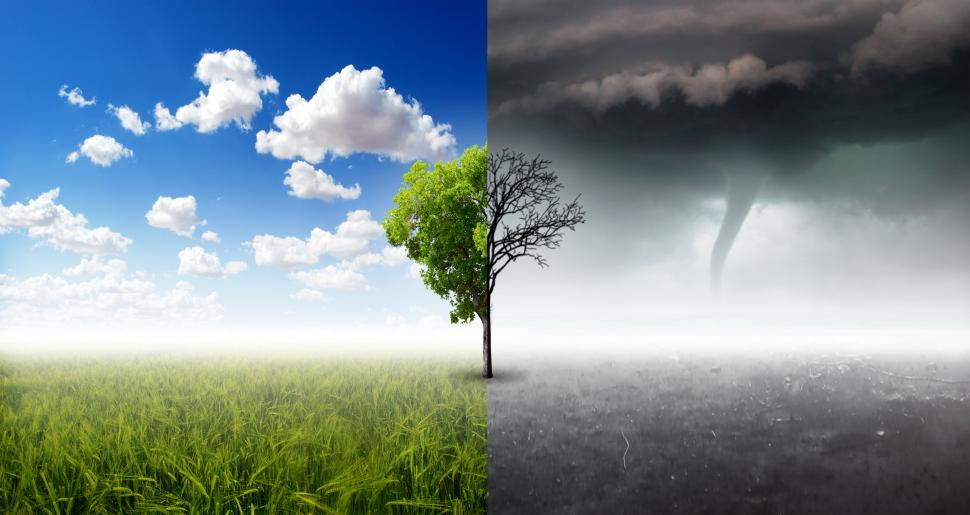

_________________

## **About the Dataset:**

* This dataset exists thanks to the generous contributions of the NASA POWER Project and the dedicated authors behind the US Drought Monitor. These groups have provided valuable data that allow us to study and predict droughts.

* The data comes from the NASA Langley Research Center (LaRC) POWER Project, funded by NASA's Earth Science/Applied Science Program. This project gathers important weather and soil information, enabling us to analyze droughts effectively.

* The US Drought Monitor, a collaboration between the National Drought Mitigation Center, the US Department of Agriculture, and the National Oceanic and Atmospheric Administration, has also played a key role. Their data helps us understand current drought conditions, making our predictions more accurate.

* We've also used the Harmonized World Soil Database, a global soil resource created by experts. This database helps us study soil properties and their connection to droughts.

* By combining these resources, we're able to explore droughts and develop methods to predict and manage them better. It's a collaborative effort that enhances our understanding of this important environmental challenge.

## **Objectives:**

* Drought Prediction: Develop a model that can predict the likelihood of drought events based on weather and soil data.

* Early Warning System: Create an early warning system that alerts relevant stakeholders about potential drought conditions in advance.

* Data Analysis: Gain insights into the relationships between weather, soil, and drought occurrences through exploratory data analysis.

_______________________________________

### <font color='green'> Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from itertools import zip_longest
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


__________

### <font color='green'> Input Data

In [3]:
data = pd.read_csv('../input/us-drought-meteorological-data/train_timeseries/train_timeseries.csv')
data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [4]:
#FIPS based on County in US

unique_fips_counts = data['fips'].value_counts()

print("Unique FIPS Values and Their Counts:")
print(f"Total Number of Counties present in the dataset for the US based on FIPS: {unique_fips_counts.count()}\n")
print("Some FIPS Values and Their Counts:")
unique_fips_counts

Unique FIPS Values and Their Counts:
Total Number of Counties present in the dataset for the US based on FIPS: 3108

Some FIPS Values and Their Counts:


1001     6210
39159    6210
39115    6210
39117    6210
39119    6210
         ... 
21159    6210
21161    6210
21163    6210
21165    6210
56043    6210
Name: fips, Length: 3108, dtype: int64

The "fips" column encompasses the comprehensive list of United States FIPS codes, categorizing counties. For the scope of our project, we're focusing on a single county to develop the model. However, our preprocessing approach can be seamlessly extended to other counties, allowing us to employ a consistent time series modeling strategy.

By concentrating on one county initially, we streamline our model development process and tailor it to the unique characteristics of that specific region. This approach ensures that our model becomes finely attuned to local conditions and produces more accurate predictions for drought events.

The beauty of our methodology lies in its adaptability. Once we've perfected our preprocessing pipeline and time series model for the chosen county, we can effortlessly apply the same process to other counties. This standardized approach maintains the integrity of our analysis and enables us to efficiently scale our predictions across different regions.

To associate each FIPS code with its corresponding county, you can refer to the comprehensive list provided on Wikipedia: https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county

This resource offers a detailed breakdown of FIPS codes, enabling you to easily identify and match specific codes to their respective counties. By leveraging this information, you can accurately determine which county each FIPS code pertains to, thereby enhancing the interpretability and relevance of your analysis for different regions.

In [5]:
#Here I took washington Country as data_ts for the forecasting 

data_ts = pd.DataFrame(data[data['fips'] == 12133])

data_ts.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
2216970,12133,2000-01-01,0.27,101.56,10.79,16.27,15.34,15.34,22.99,11.85,...,16.05,2.94,3.88,2.28,1.59,5.13,5.77,3.74,2.03,NaN
2216971,12133,2000-01-02,0.28,101.63,11.30,17.25,16.11,16.11,23.60,12.81,...,17.05,3.25,4.42,2.46,1.95,5.56,6.40,4.20,2.20,NaN
2216972,12133,2000-01-03,0.94,101.35,11.14,17.52,15.83,15.82,23.99,12.71,...,17.36,4.05,5.90,3.01,2.89,6.87,7.99,4.40,3.59,NaN
2216973,12133,2000-01-04,5.40,101.23,8.79,15.50,10.88,10.89,20.30,5.72,...,15.36,5.77,7.08,4.54,2.54,8.68,9.46,7.77,1.69,1.0
2216974,12133,2000-01-05,0.00,102.05,3.45,5.69,-1.17,-1.11,12.28,0.57,...,6.09,3.37,4.91,1.99,2.92,5.34,7.82,3.16,4.66,NaN


_________________________________

### <font color='green'> Initial Exploration

In [6]:
# summary statistics of the dataset

display(data_ts.describe())

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,6210.0,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,887.000000
mean,12133.0,3.806164,101.211016,11.555084,19.411485,14.822718,14.829671,25.096006,14.170663,10.925396,19.578899,3.102958,4.514296,1.808010,2.706348,4.900522,6.748767,2.969655,3.779097,0.884449
std,0.0,8.394451,0.476185,4.765635,7.552779,7.584027,7.570020,7.179591,8.182484,3.271726,7.682839,1.196126,1.721266,0.970928,1.216880,1.762855,2.001181,1.830081,1.456099,1.312806
min,12133.0,0.000000,99.110000,1.710000,-4.060000,-10.010000,-9.700000,-1.410000,-7.650000,2.110000,-2.820000,0.820000,1.280000,0.020000,0.390000,1.170000,1.950000,0.020000,0.930000,0.000000
25%,12133.0,0.000000,100.900000,7.470000,13.872500,9.482500,9.490000,20.290000,7.722500,8.620000,13.842500,2.240000,3.200000,1.070000,1.840000,3.590000,5.460000,1.440000,2.742500,0.000000
50%,12133.0,0.310000,101.180000,11.735000,20.535000,16.550000,16.550000,26.190000,15.145000,10.940000,20.550000,2.895000,4.220000,1.830000,2.480000,4.690000,6.430000,2.790000,3.580000,0.000000
75%,12133.0,3.810000,101.500000,15.797500,26.050000,21.330000,21.330000,30.790000,21.970000,13.280000,26.180000,3.760000,5.507500,2.460000,3.290000,6.007500,7.660000,4.287500,4.570000,1.273700
max,12133.0,100.760000,103.410000,20.900000,32.840000,25.830000,25.830000,40.270000,27.370000,21.850000,33.820000,12.510000,17.070000,8.400000,11.200000,17.350000,22.760000,11.510000,13.830000,5.000000


In [7]:
def categorical_numerical_table(data):
    """
    Creates a table with categorical and numerical column names from a DataFrame.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    aligned_columns = list(zip_longest(categorical_columns, numeric_columns, fillvalue=''))
    column_table = pd.DataFrame({'Numerical Columns': [num_col for cat_col, num_col in aligned_columns],
                                 'Categorical Columns': [cat_col for cat_col, num_col in aligned_columns],
                                 },
                                index=range(1, len(aligned_columns) + 1))

    return column_table

numerical_columns = categorical_numerical_table(data)['Numerical Columns'].tolist()
categorical_columns = categorical_numerical_table(data)['Categorical Columns'].tolist()

print("Note: I will convert the date into date type in the preprocessing.\n\n")
categorical_numerical_table(data_ts)

Note: I will convert the date into date type in the preprocessing.




,Numerical Columns,Categorical Columns
1,fips,date
2,PRECTOT,
3,PS,
4,QV2M,
5,T2M,
6,T2MDEW,
7,T2MWET,
8,T2M_MAX,
9,T2M_MIN,
10,T2M_RANGE,


In [8]:
#Checking for the Null

data_ts.isnull().sum()

fips              0
date              0
PRECTOT           0
PS                0
QV2M              0
T2M               0
T2MDEW            0
T2MWET            0
T2M_MAX           0
T2M_MIN           0
T2M_RANGE         0
TS                0
WS10M             0
WS10M_MAX         0
WS10M_MIN         0
WS10M_RANGE       0
WS50M             0
WS50M_MAX         0
WS50M_MIN         0
WS50M_RANGE       0
score          5323
dtype: int64

In [9]:
#Duplicates from the dataset

data_ts[data_ts.duplicated()]

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score


In [10]:
#Shape of the data_ts

data_ts.shape

(6210, 21)

In [11]:
#Converting date from object type to date type

data_ts['date'] = pd.to_datetime(data_ts['date'])



#Extracting Day, Month and Year for the Analysis

data_ts['year'] = pd.DatetimeIndex(data_ts['date']).year
data_ts['month'] = pd.DatetimeIndex(data_ts['date']).month
data_ts['day'] = pd.DatetimeIndex(data_ts['date']).day

data_ts.dtypes

fips                    int64
date           datetime64[ns]
PRECTOT               float64
PS                    float64
QV2M                  float64
T2M                   float64
T2MDEW                float64
T2MWET                float64
T2M_MAX               float64
T2M_MIN               float64
T2M_RANGE             float64
TS                    float64
WS10M                 float64
WS10M_MAX             float64
WS10M_MIN             float64
WS10M_RANGE           float64
WS50M                 float64
WS50M_MAX             float64
WS50M_MIN             float64
WS50M_RANGE           float64
score                 float64
year                    int64
month                   int64
day                     int64
dtype: object

In [12]:
#Backward Filling for the Null values

data_ts['score'] = data_ts['score'].fillna(method='bfill')

__________________________________

### <font color='green'>Exploratory Data Analysis

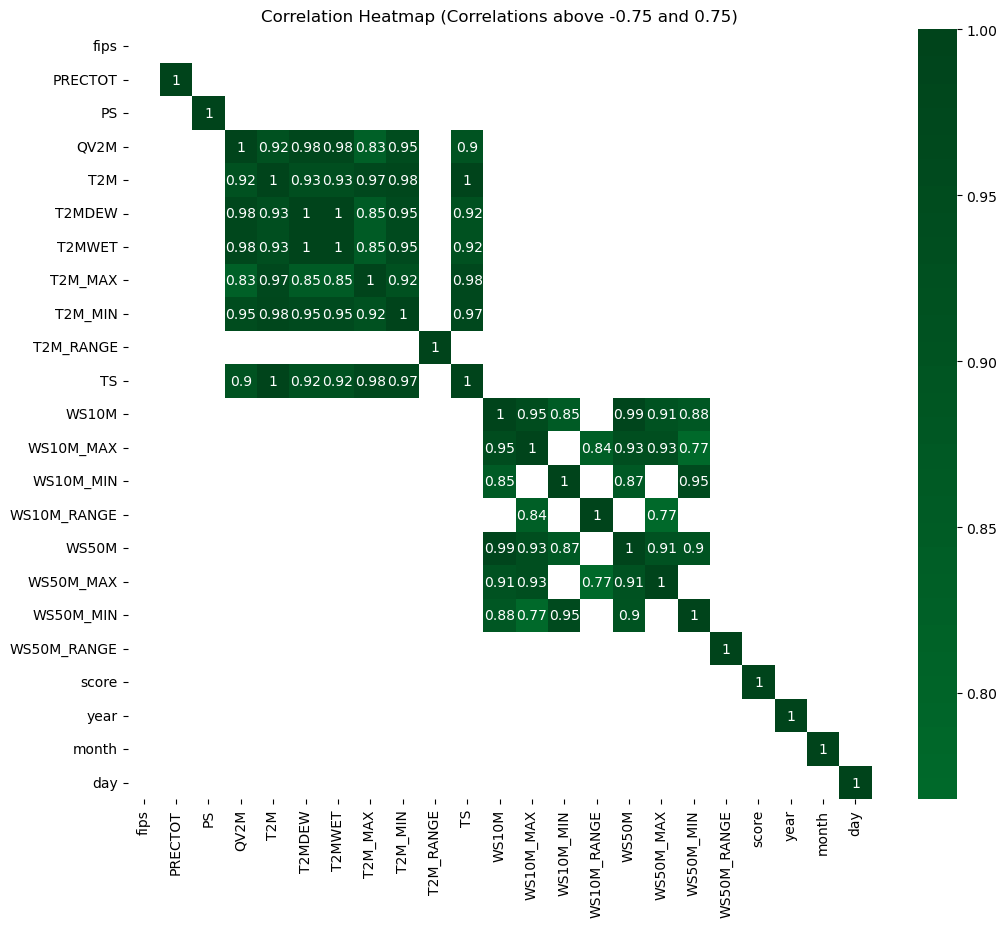

In [13]:
# Heatmap with the feature correlation that are highly correlated above 0.57 in the positive and negaive range.

correlation_matrix = data_ts.corr()

filtered_correlations = correlation_matrix[(correlation_matrix <= -0.75) | (correlation_matrix >= 0.75)]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlations, annot=True, cmap='Greens', center=0)
plt.title("Correlation Heatmap (Correlations above -0.75 and 0.75)")
plt.show()

**Strong Positive Correlation:** 

When the QV2M (specific humidity) increases, the T2M (temperature at 2 meters above ground level) tends to increase as well. The same applies for QV2M and T2MDEW (dew point temperature at 2 meters) as well as QV2M and T2MWET (wet bulb temperature at 2 meters). Similarly, T2M and T2MDEW, T2M and T2MWET, and T2MDEW and T2MWET show strong positive correlations, indicating that when one of these temperatures rises, the others tend to rise as well.

**Moderate Positive Correlation:** 

There's a moderate positive correlation between QV2M and T2M_MAX, suggesting that as specific humidity increases, the maximum temperature at 2 meters tends to increase moderately.

**Strong Positive Correlation - Wind Speed:** 

Wind speeds at 10 meters (WS10M) show strong positive correlations with various factors. For example, WS10M and WS10M_MAX (maximum wind speed at 10 meters) are strongly positively correlated, indicating that higher average wind speeds are associated with higher maximum wind speeds. Additionally, WS10M has a strong positive correlation with WS50M (wind speed at 50 meters), indicating that changes in wind speed at 10 meters are likely reflected in wind speed at 50 meters.

**Very Strong Positive Correlation - Temperature:** 

T2M and TS (surface temperature) exhibit a very strong positive correlation. This indicates that changes in temperature at 2 meters closely mirror changes in surface temperature.

**Very Strong Positive Correlation - Dew Point and Wet Bulb:** 

T2MDEW and T2MWET show a very strong positive correlation. This suggests that changes in dew point temperature at 2 meters closely correspond to changes in wet bulb temperature at 2 meters.

**Very Strong Positive Correlation - Wind Speed:** 

WS10M and WS10M_RANGE (range of wind speed at 10 meters) have a very strong positive correlation. This suggests that when average wind speed at 10 meters is higher, the range of wind speeds also tends to be higher.

**Strong Positive Correlation - Wind Speed and Wind Range:** 

WS10M and WS50M_MAX (maximum wind speed at 50 meters) show a strong positive correlation, indicating that higher average wind speeds at 10 meters are associated with higher maximum wind speeds at 50 meters. Similarly, WS10M_RANGE and WS50M_MAX exhibit a strong positive correlation, implying that greater variability in wind speeds at 10 meters corresponds to higher maximum wind speeds at 50 meters.

**Moderate Positive Correlation - Wind Speed:** 

WS10M_RANGE and WS50M_MAX have a moderate positive correlation, suggesting that some variability in wind speeds at 10 meters is related to moderately higher maximum wind speeds at 50 meters.

**Strong Positive Correlation - Wind Speed and Wind Min:** 

WS10M and WS50M_MIN (minimum wind speed at 50 meters) are strongly positively correlated, indicating that higher average wind speeds at 10 meters correspond to higher minimum wind speeds at 50 meters.

**Strong Positive Correlation - Wind Min:** 

WS10M_MIN and WS50M_MIN show a strong positive correlation, suggesting that higher minimum wind speeds at 10 meters correspond to higher minimum wind speeds at 50 meters.

____________________________

### <font color='green'>Univariate Analysis - Distribution of continuous variables

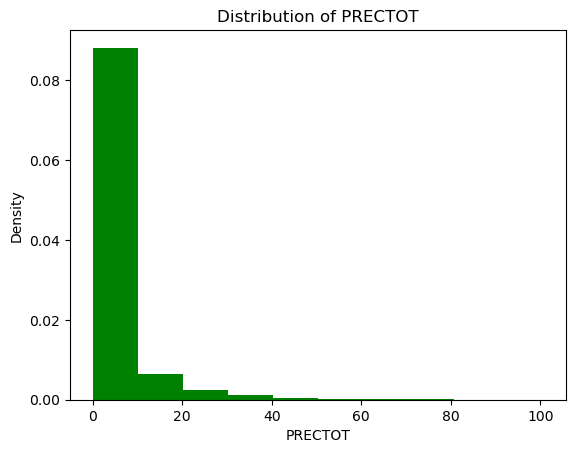

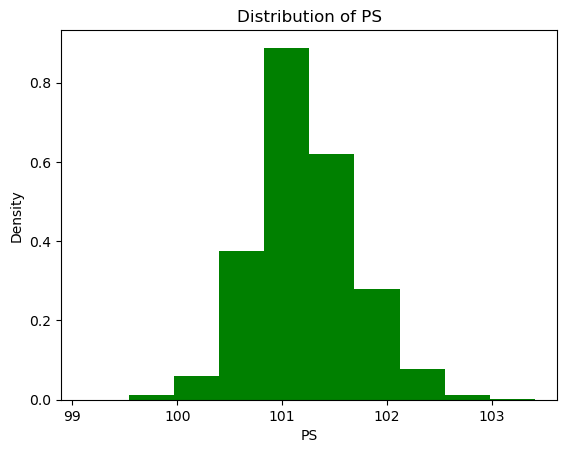

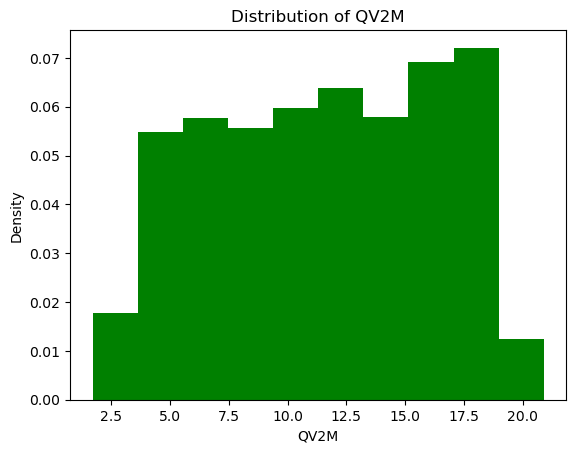

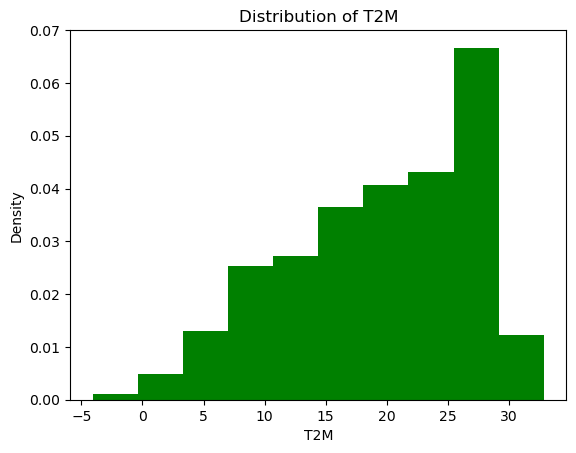

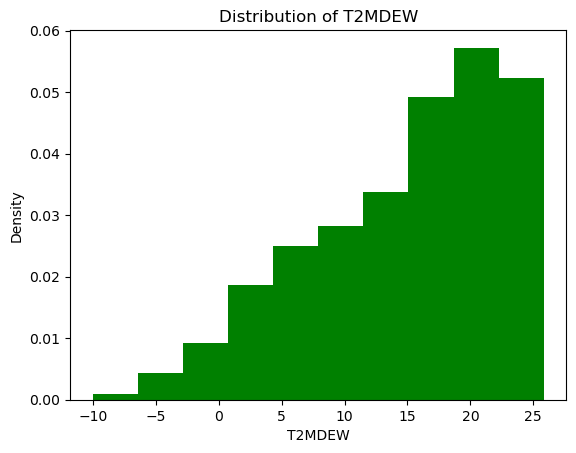

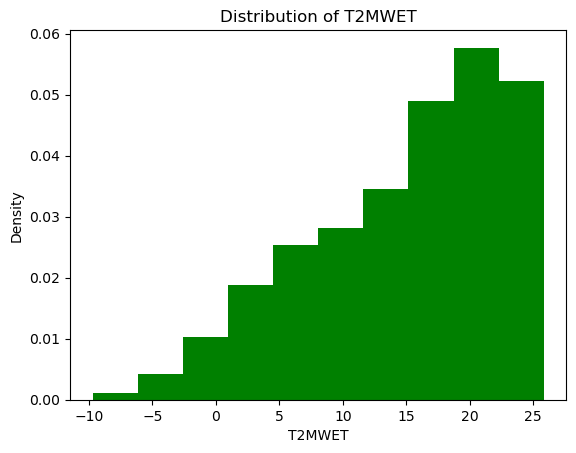

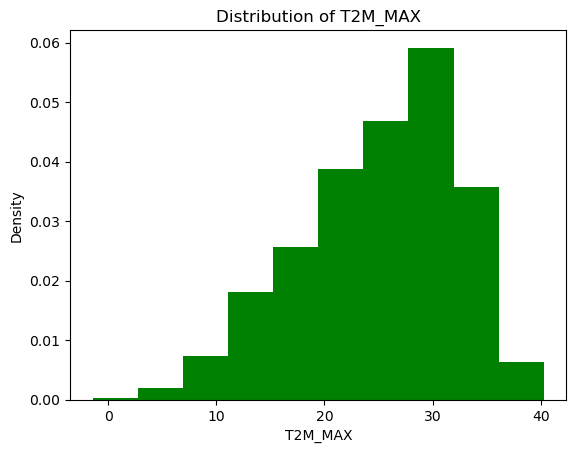

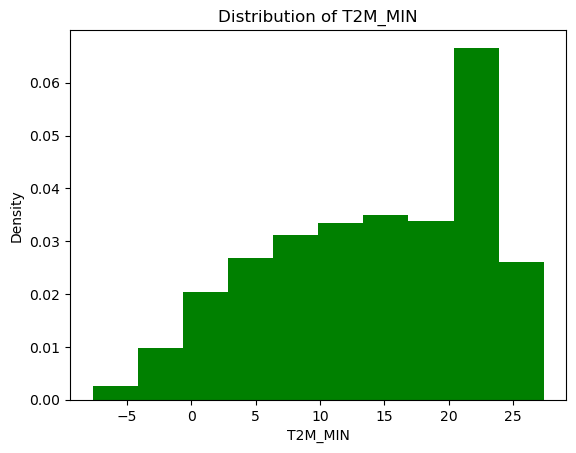

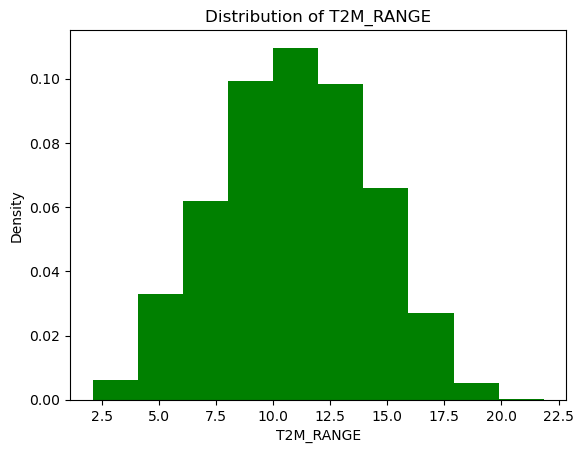

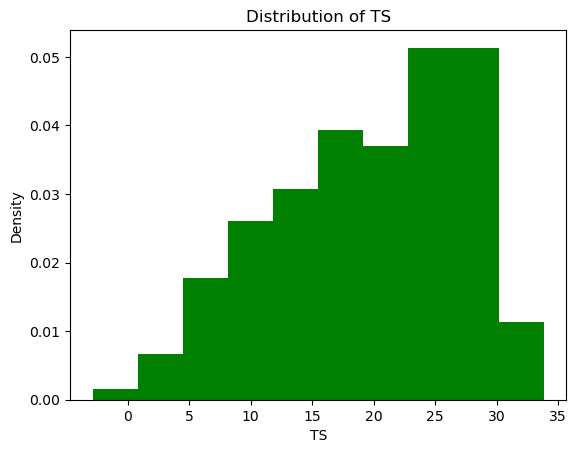

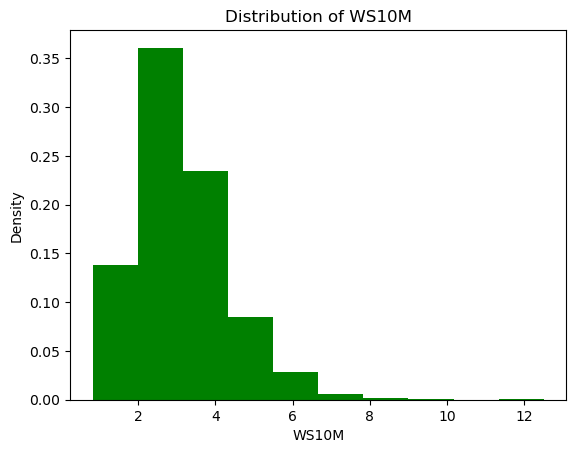

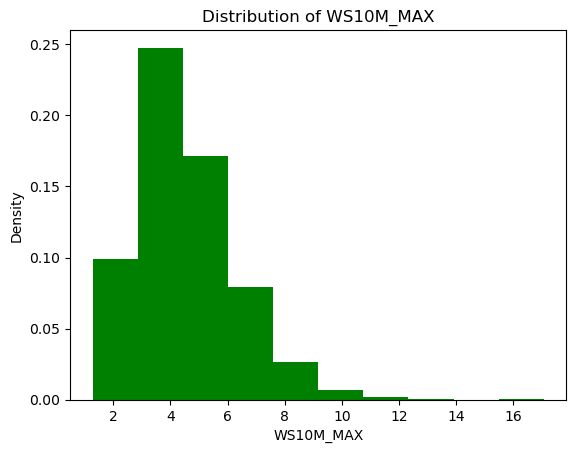

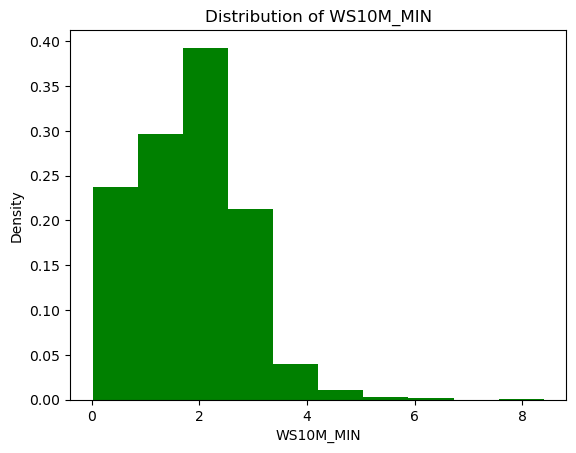

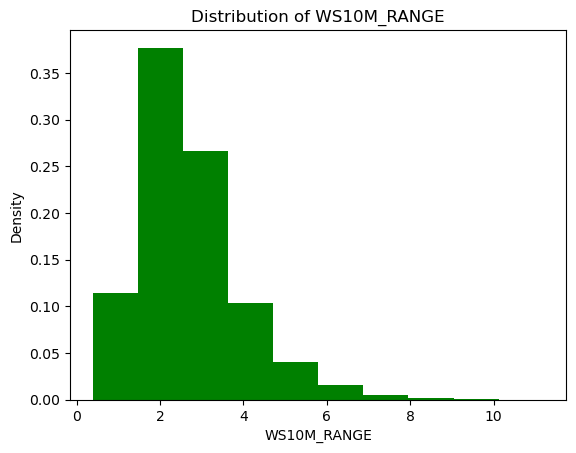

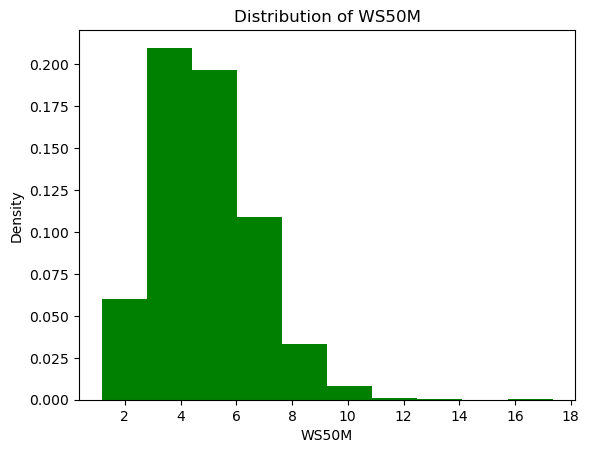

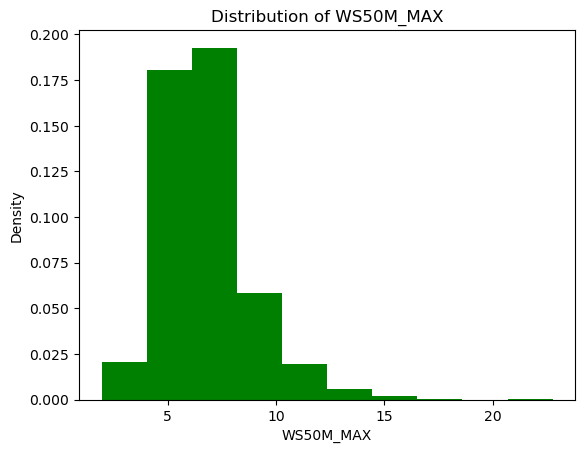

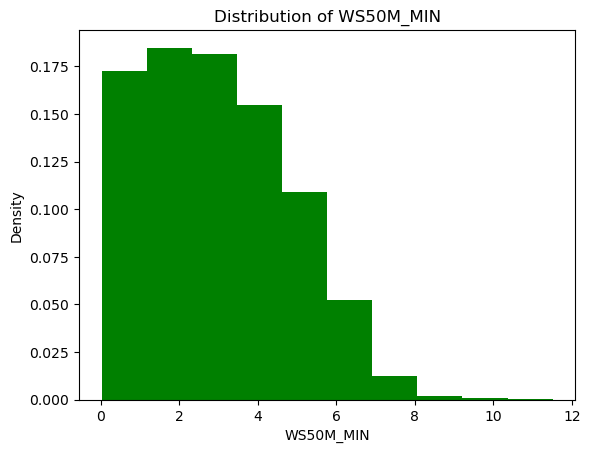

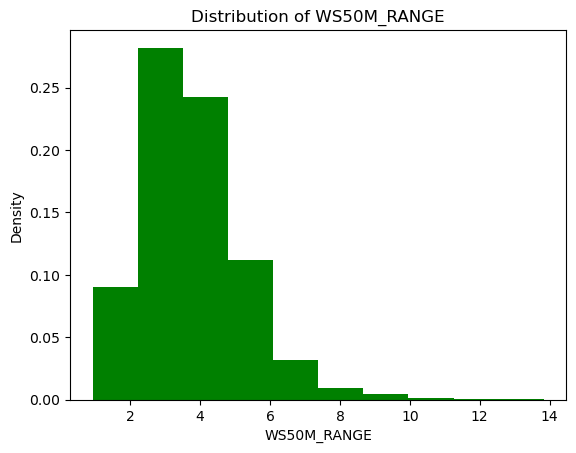

In [14]:
#Distribution of all the continuous variables

measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
data_ts_measures = data_ts[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

for col_name in measures_column_list:
    plt.figure()
    plt.hist(data_ts_measures[col_name], density = True, color = 'green')
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

_________________________

### <font color='green'>Bivariate Analysis

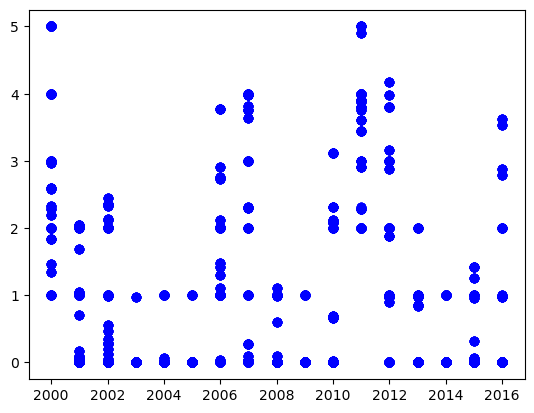

In [15]:
#Scatter Plot for the Year and Score

plt.scatter(data_ts['year'], data_ts['score'], c ="blue")
plt.show()

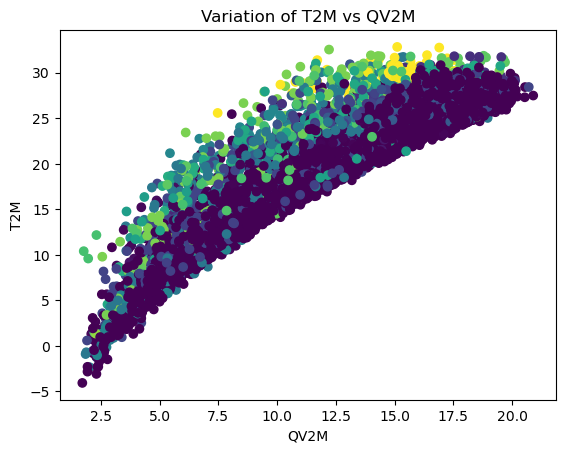

In [16]:
plt.scatter(data_ts['QV2M'], data_ts['T2M'], c =data_ts['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.show()

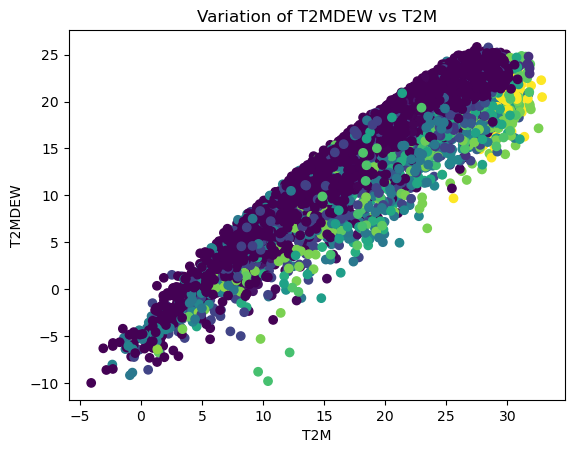

In [17]:
plt.scatter(data_ts['T2M'], data_ts['T2MDEW'], c =data_ts['score'])
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
plt.show()

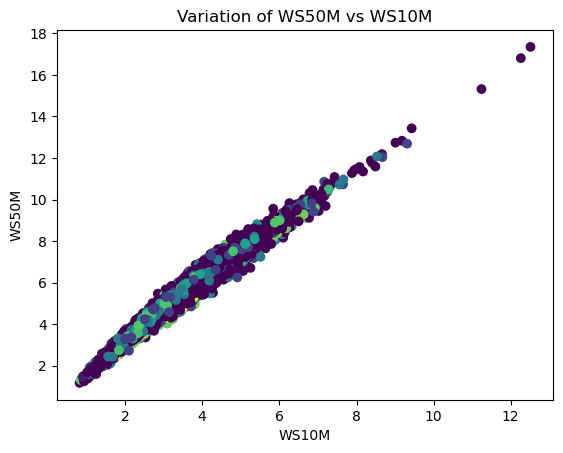

In [18]:
temp_df = data_ts[data_ts['score']==5]
plt.scatter(data_ts['WS10M'], data_ts['WS50M'], c= data_ts['score'])
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
plt.show()

_____________________

### <font color='green'> Pattern Recognition Using Plots

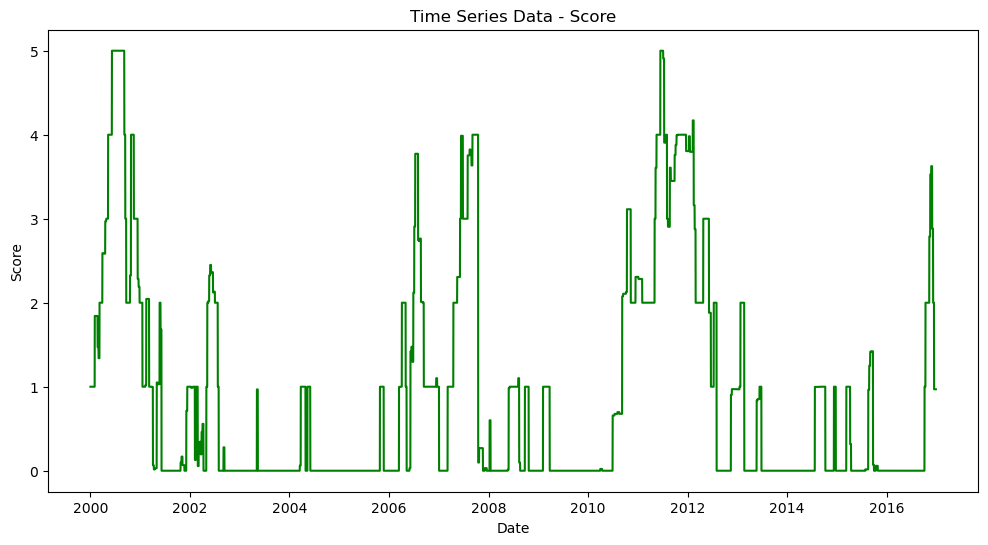

In [19]:
#Pattern of score over the years

plt.figure(figsize=(12, 6))
plt.plot(data_ts['date'], data_ts['score'], color = 'green')
plt.title('Time Series Data - Score')
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

The alternating pattern of upward and downward trends, along with intermittent fluctuations, suggests the presence of seasonality or cyclical behavior in your time series data. The specific years of notable changes could be influenced by various factors such as external events, policy changes, or underlying patterns in the data itself.

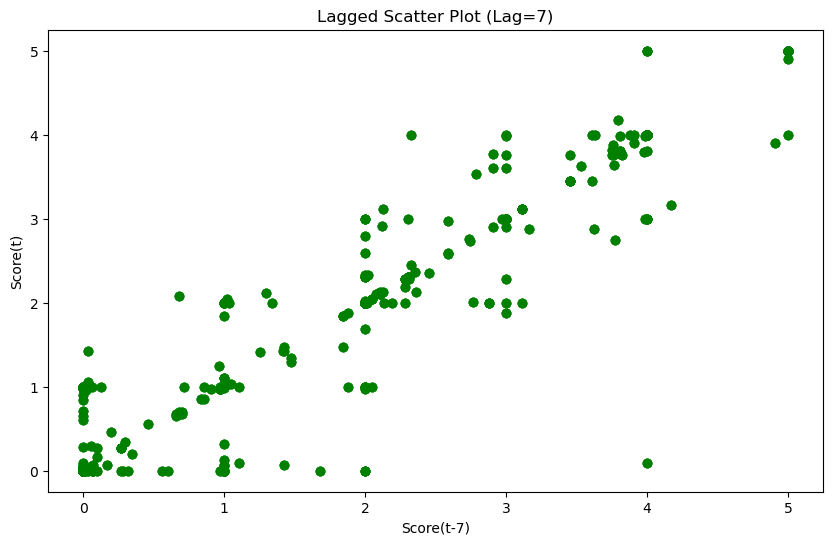

In [20]:
#Scatter plot with the lag of 7 (week)

lag = 7 
plt.figure(figsize=(10, 6))
plt.scatter(data_ts['score'].shift(lag), data_ts['score'], alpha=0.5, color = 'green')
plt.title(f'Lagged Scatter Plot (Lag={lag})')
plt.xlabel(f'Score(t-{lag})')
plt.ylabel('Score(t)')
plt.show()

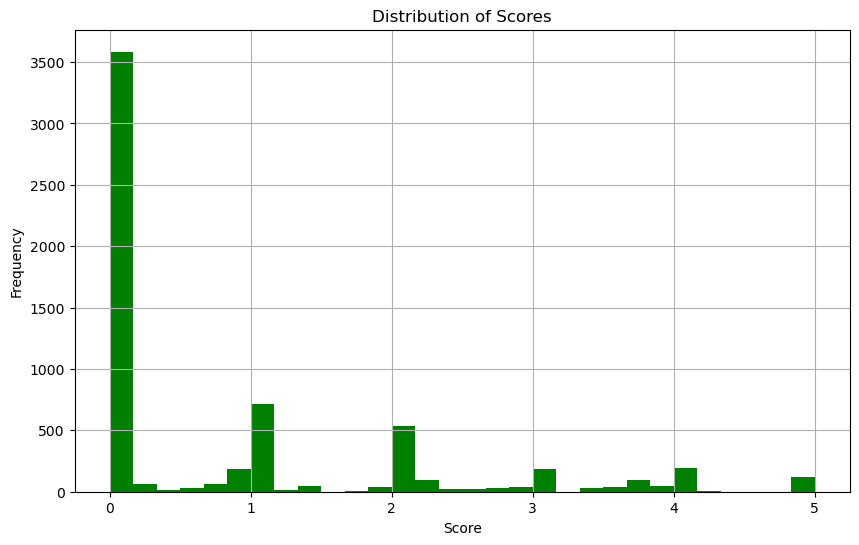

In [21]:
#Scores Distribution Plot

plt.figure(figsize=(10, 6))
data_ts['score'].hist(bins=30, color = 'green')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

This distribution shows that the score of 0 appears very often. Scores 1, 2, 3, 4, and 5 are also quite common. However, floating scores between 0 and 4 have lower frequencies, suggesting they occur less frequently in the data.

__________________________________

### <font color='green'> Skewness


Skewness: 
 fips           0.000000
PRECTOT        4.333936
PS             0.270360
QV2M          -0.111058
T2M           -0.534681
T2MDEW        -0.707009
T2MWET        -0.700946
T2M_MAX       -0.535863
T2M_MIN       -0.425596
T2M_RANGE     -0.028133
TS            -0.446801
WS10M          1.139381
WS10M_MAX      1.053074
WS10M_MIN      0.486575
WS10M_RANGE    1.290574
WS50M          0.770819
WS50M_MAX      1.347562
WS50M_MIN      0.455466
WS50M_RANGE    1.176677
score          1.462909
year           0.000000
month         -0.009091
day            0.006626
dtype: float64


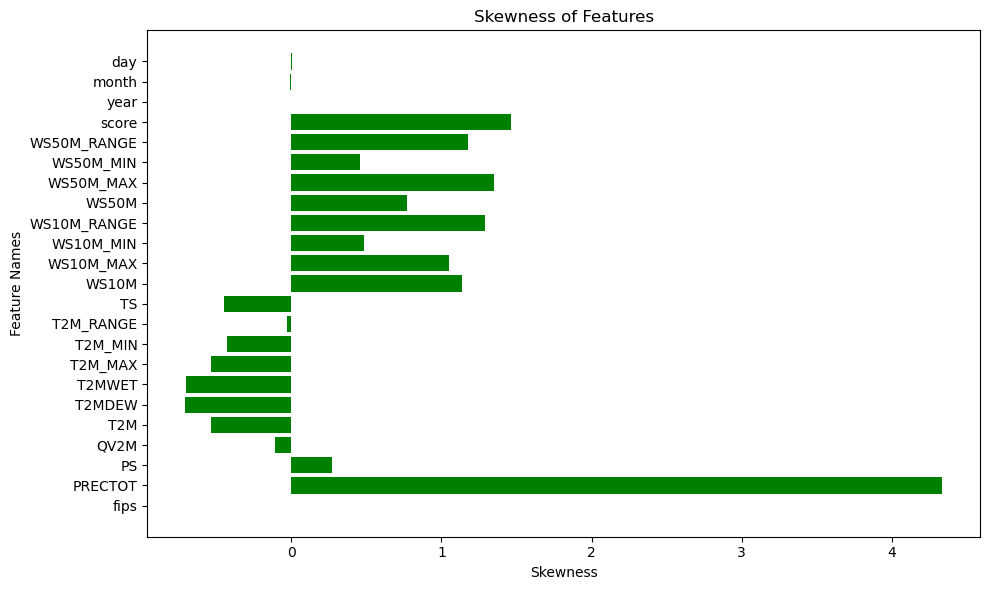

In [22]:
skewness_result = data_ts.skew(axis=0, skipna=True)
feature_names = skewness_result.index.tolist()
skewness_values = skewness_result.tolist()


print("\nSkewness: \n", skewness_result)


plt.figure(figsize=(10, 6))
plt.barh(feature_names, skewness_values, color='green')
plt.xlabel('Skewness')
plt.ylabel('Feature Names')
plt.title('Skewness of Features')
plt.tight_layout()

# Display the plot
plt.show()

**Skewness:**

fips (County Code): Symmetrical distribution (skewness close to 0), indicating a balanced spread of county codes.

PRECTOT (Total Precipitation): Highly positively skewed, suggesting a long tail on the right side, indicating a concentration of lower precipitation values and some extreme values.

PS (Surface Pressure): Slightly positively skewed, indicating a relatively balanced distribution with a slight tail on the right side.

QV2M (Specific Humidity at 2m): Slightly negatively skewed, suggesting a slight tail on the left side, potentially indicating higher values.

T2M (Temperature at 2m): Slightly negatively skewed, similar to QV2M, implying a slight tail on the left side.

T2MDEW (Dew/Frost Point Temperature at 2m): Slightly negatively skewed, suggesting a slight tail on the left side.

T2MWET (Wet Bulb Globe Temperature at 2m): Slightly negatively skewed, indicating a slight tail on the left side.

T2M_MAX (Max Temperature at 2m): Slightly negatively skewed, suggesting a slight tail on the left side.

T2M_MIN (Min Temperature at 2m): Slightly negatively skewed, similar to T2M_MAX, implying a slight tail on the left side.

T2M_RANGE (Temperature Range at 2m): Very close to symmetrical (skewness close to 0), indicating a balanced spread of values.

TS (Earth Skin Temperature): Slightly negatively skewed, suggesting a slight tail on the left side.

WS10M (Wind Speed at 10m): Moderately positively skewed, indicating a concentration of lower wind speeds and some higher values.

WS10M_MAX (Max Wind Speed at 10m): Moderately positively skewed, suggesting a concentration of lower max wind speeds and some higher values.

WS10M_MIN (Min Wind Speed at 10m): Positively skewed, indicating a concentration of lower min wind speeds and some higher values.

WS10M_RANGE (Wind Speed Range at 10m): Moderately positively skewed, indicating a concentration of lower wind speed ranges and some higher values.

WS50M (Wind Speed at 50m): Positively skewed, suggesting a concentration of lower wind speeds and some higher values.

WS50M_MAX (Max Wind Speed at 50m): Moderately positively skewed, indicating a concentration of lower max wind speeds and some higher values.

WS50M_MIN (Min Wind Speed at 50m): Positively skewed, indicating a concentration of lower min wind speeds and some higher values.

WS50M_RANGE (Wind Speed Range at 50m): Moderately positively skewed, indicating a concentration of lower wind speed ranges and some higher values.

score: Positively skewed, indicating a concentration of lower scores and some higher values.

_________________________________

### <font color='green'> Kurtosis


Kurtosis: 
 fips            0.000000
PRECTOT        26.181618
PS              0.524885
QV2M           -1.172422
T2M            -0.671873
T2MDEW         -0.399735
T2MWET         -0.419116
T2M_MAX        -0.346157
T2M_MIN        -0.947546
T2M_RANGE      -0.479844
TS             -0.765866
WS10M           2.678207
WS10M_MAX       1.829231
WS10M_MIN       1.088171
WS10M_RANGE     2.641266
WS50M           1.264271
WS50M_MAX       3.838515
WS50M_MIN      -0.394375
WS50M_RANGE     2.994370
score           1.144530
year           -1.208311
month          -1.208240
day            -1.194180
dtype: float64


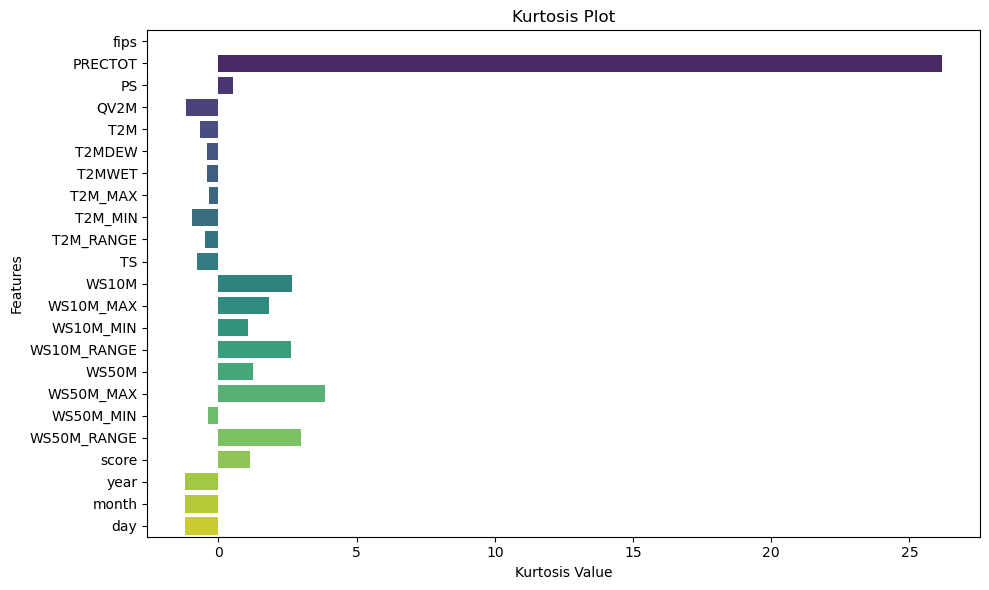

In [23]:
kurtosis_result = data_ts.kurtosis(axis=0, skipna=True)
feature_names = kurtosis_result.index.tolist()
kurtosis_values = kurtosis_result.tolist()


print("\nKurtosis: \n", kurtosis_result)


plt.figure(figsize=(10, 6))
sns.barplot(x=kurtosis_values, y=feature_names, palette='viridis')
plt.title('Kurtosis Plot')
plt.xlabel('Kurtosis Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

**Kurtosis:**

fips: The distribution of this feature closely resembles a normal distribution (kurtosis value of 0.0).

PRECTOT: This feature has a high kurtosis value (26.181618), indicating heavy-tailedness and potentially some extreme values in its distribution.

PS: The distribution of this feature is slightly more peaked compared to a normal distribution (positive kurtosis value of 0.524885).

QV2M: The distribution of this feature is slightly less peaked compared to a normal distribution (negative kurtosis value of -1.172422).

T2M: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.671873).

T2MDEW: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.399735).

T2MWET: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.419116).

T2M_MAX: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.346157).

T2M_MIN: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.947546).

T2M_RANGE: The distribution of this feature is slightly less peaked compared to a normal distribution (negative kurtosis value of -0.479844).

TS: The distribution of this feature is moderately less peaked compared to a normal distribution (negative kurtosis value of -0.765866).

WS10M: This feature has a positive kurtosis value (2.678207), indicating heavy-tailedness and potentially some extreme values in its distribution.

WS10M_MAX: This feature has a positive kurtosis value (1.829231), indicating heavy-tailedness and potentially some extreme values in its distribution.

WS10M_MIN: This feature has a positive kurtosis value (1.088171), indicating heavy-tailedness and potentially some extreme values in its distribution.

WS10M_RANGE: This feature has a positive kurtosis value (2.641266), indicating heavy-tailedness and potentially some extreme values in its distribution.

WS50M: This feature has a positive kurtosis value (1.264271), indicating heavy-tailedness and potentially some extreme values in its distribution.

WS50M_MAX: This feature has a very high positive kurtosis value (3.838515), indicating significant heavy-tailedness and potentially many extreme values in its distribution.

WS50M_MIN: The distribution of this feature is slightly less peaked compared to a normal distribution (negative kurtosis value of -0.394375).

WS50M_RANGE: This feature has a positive kurtosis value (2.994370), indicating heavy-tailedness and potentially some extreme values in its distribution.

score: The distribution of this feature is moderately less peaked compared to a normal distribution (kurtosis value of 1.144530).

________________________________________

### <font color='green'> Outlier Detection

In [24]:
#Removing Outliers based on the five outlier detection models along with ranged parameters 

models = [
    ('Isolation Forest', IsolationForest(contamination=0.05, random_state=10)),
    ('Local Outlier Factor', LocalOutlierFactor(contamination=0.05)),
    ('One-Class SVM', OneClassSVM(nu=0.05)),
    ('Elliptic Envelope', EllipticEnvelope(contamination=0.05)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5))
]

#Outliers are removed based on the threshold. This can be adjusted accordingly.

threshold = 2.5

outlier_indices = {}

for name, model in models:
    if name == 'DBSCAN':
        labels = model.fit_predict(data_ts.drop(columns=['date', 'score']))
        scores = -labels  # Using labels for DBSCAN (DBSCAN doesn't have negative_outlier_factor_)
    else:
        scores = model.fit_predict(data_ts.drop(columns=['date', 'score']))
        scores = -scores
    outlier_indices[name] = data_ts.index[scores > threshold]

all_outlier_indices = np.concatenate(list(outlier_indices.values()))

data_without_outliers = data_ts.drop(index=all_outlier_indices)

_____________________________

### <font color='green'> Data Split

In [25]:
X = data_without_outliers.drop(columns=['date', 'score'])
y = data_without_outliers['score']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

_______________________

### <font color='green'> Model Building

In [27]:
#SARIMAX Model building

sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)) 
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94276D+00    |proj g|=  1.97324D-01


 This problem is unconstrained.



At iterate    5    f=  1.72534D+00    |proj g|=  5.55042D-02

At iterate   10    f=  1.68852D+00    |proj g|=  4.12309D-03

At iterate   15    f=  1.68533D+00    |proj g|=  4.20925D-03
  ys=-4.089E-04  -gs= 1.950E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  1.68473D+00    |proj g|=  1.26603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     54      2     1     0   3.413D-05   1.685D+00
  F =   1.6847281085746955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [28]:
#Prediction of y_train

sarima_predictions = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
sarima_predictions

4347    0.867684
4348    1.021337
4349    0.913932
4350    0.958238
4351    0.949956
          ...   
6205    0.964511
6206    0.956460
6207    0.863119
6208    0.974300
6209    0.884241
Name: predicted_mean, Length: 1863, dtype: float64

In [29]:
#Evalucation Metrics

mse_sarima = mean_squared_error(y_test, sarima_predictions)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(y_test, sarima_predictions)


print("SARIMA Model Metrics:")
print("Mean Squared Error:", mse_sarima)
print("Root Mean Squared Error:", rmse_sarima)
print("Mean Absolute Error:", mae_sarima)

SARIMA Model Metrics:
Mean Squared Error: 1.788477480921244
Root Mean Squared Error: 1.337339702888254
Mean Absolute Error: 1.059281461162057


_____________________________________

* The optimization algorithm successfully minimized the objective function (likely the mean squared error) to the final function value of approximately 1.681.

* The Root Mean Squared Error (RMSE) is approximately 1.37, which indicates the average magnitude of the prediction errors. Lower RMSE values indicate better model performance.

* The Mean Absolute Error (MAE) is approximately 1.08, which represents the average absolute difference between the predicted and actual values. Lower MAE values also indicate better model performance.

____________________________________

By applying preprocessing steps through a pipeline and replacing the FIPS values, we can forecast the scores for different counties (areas) in the US. While we have the opportunity to leverage the entire dataset and explore the application of LSTM and other models, for the sake of this illustration, I concentrated on constructing a time series model using the SARIMA approach. Thanks.


_______________